# Segmentation of Skeletal Stem Cell Nuclei in Phase Contrast images

**Stem Cells** are of great interest from many points of view, since they are
central to generation, homeostatic regeneration and repair of tissues. Despite
the excitement due to their potential marvelous therapeutic use, much about them
is still unknown.

One of these still undiscovered aspects concerns the structure of the growth of
the clonal progeny. If we were to trace the "ancestry tree" of a cell, tracing a
line for each visible cell and a bifurcation at each mitotic step, how does the
tree look like? Does it have a symmetric or an asymmetric structure? What does
this tell us about the original cell?

**Skeletal Stem Cells** (SSCs) are a type of Stem Cell which comes from human
bones.  We know that they proliferate *in vitro* and create clonal colonies from
fibroblast colony-forming units (called CFU-Fs). These colonies of SSCs reach
full confluency over a period of two weeks.

We study the **time evolution of a SSC clonal colony** extracted from the bone
marrow of a patient. The sample is cleaned from impurities and put in a Petri
dish along with the culture medium. The dish is then installed in the phase
contrast microscope, which will be taking pictures of selected Fields of View
(FOVs) every twenty minutes. The data acquisition lasts about two weeks, at the
end of which we expect that the clonal colony gets so densely packed that cells
start to get out of the FOV. Note that some of the FOVs do not generate colonies
at all: cells that are quiescent are removed from the selection of FOVs after a
while.

In [1]:
import os
from pathlib import Path
from functools import partial
import numpy as np
import cv2
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.image import ImageDataGenerator

ModuleNotFoundError: No module named 'tensorflow'

## Tracking Cells in Phase Contrast Images of SSCs

In order to trace the **phylogenetic tree** of cells it is necessary to see at
each frame where each cell is located, whether they perform mitosis and which
cells are generated from the mitosis of which other cell. Such a task is done
by **cell tracking**.

In order to track a cell it is necessary to understand where it is located. One
popular way to achieve this is to perform what is called a **semantic
segmentation**: if we think of the image as an array of elements, semantic
segmentation means that we say whether each one of these array elements belongs
to a class or not.

Semantic segmentation can:

- Be performed over *slides* (i.e. the image is a 2D array) or *volumes* (the image
    is a 3D array). The former can be, for example, the case of microscopy of
    bacteria or cells, and the latter can be the case of MRI images of body
    organs (brain, liver, heart, etc.).
- Be performed over *colored images* (i.e. each array element is a 3D array in
    itself, usually containing an integer value from 0 to 255 that refers to the
    intensity of the red, green or blue component) or *greyscale images* (i.3.
    each array element is an integer value from 0 to 255 referring to the
    brightness of the pixel). The former is the case, for example, of
    fluorescence microscopy and the latter can be the case of phase contrast
    microscopy of unstained samples (which is exactly our case).
- Yield as a result *two classes* (one relevant class, aka the foreground, and
    the background) or *more than two classes* (multiple relevant classes, e.g.
    the brain tumor, the rest of the brain, the background).

We can attempt semantic segmentation by very simple and affordable means:
**image processing operations**, or a combination of them, can yield to sensible
results depending on the type of image that we are sampling.

For example, images of cells with fluorescent dyes can have very evident
features highlighting different parts of the cell, even by using multiple stains
for different components. In that case, for example, operations such as the
*watershed algorithm* can be performed and may work well enough for the
purposes of semantic segmentation.

We might as well have unstained samples of round objects with clear boundaries.
In that case we might use *boundary detection* algorithms in order to trace the
paths of boundaries of cells, hence locating their position.

Ours is none of these cases. In fact our images are **phase contrast** images,
which creates artefacts that do not allow a trivial segmentation e.g. by
thresholding, and the objects of our study are SSCs which have a
**fibroblastoid** shape, meaning that their structural appearance is that of
fibroblasts. These types of cells assume a heterogeneous variety of shapes, like
a *reticular* conformation or a *fusiform* shape; their dimension varies a lot
and over the course of the colony formation they can overlap between each other,
making trivial segmentation processes very difficult.

The lab's current state of art process for segmentation of SSCs implies the use
of an image processing based segmentation routine over their **cytoplasm**. This
process works very well for early stages of the colony formation, but becomes
ineffective as cells start to stretch and overlap. This happens after ca. five
to six generations, and consequently impedes any further cell tracking.

We attempt at **augmenting the tracking algorithm** by providing the already
developed algorithm for segmentation of cell cytoplasm with **additional
informations about cell nuclei**. We hope to achieve this by training a Deep
Convolutional Neural Networks to perform semantic segmentation of SSC nuclei.

For this purpose, two main goals were set:

- To **create a dataset** specific to our goal, selecting FOVs, tagging nuclei
    and preprocessing images in order to fit the input requirements of the DNN.
    Our images are **phase contrast grayscale images** of **fibroblastoid**
    cells, and our ground truths label the foreground (i.e. nuclei) from the
    background (i.e. all the rest). We would like to point out that the tagging
    process depends entirely on the tagger and her/his perception and knowledge.
    This already gives us a hint that overfitting too much will probably be
    problematic. We will not thoroughly present this part of the research work.
- To **create and train a model** for semantic segmentation to be feeded with
    the dataset we previously created and test its performance.

## Hardware and software setup

For the purposes of the creation of the dataset scripts using ImageJ, Python and
Bash were written.

For the DNN part instead the **Tensorflow/Keras** on Python backend was used.
OpenCV, NumPy, Matplotlib and Standard Library APIs have also been used.

## The images and the ground truths

### Properties of the images

The images we are studying, as already mentioned, are grayscale images of SSCs. SSCs
are, like many other biological assays, transparent items. This means that transmitted
light is not in any way attenuated by the sample, making the method uneffective for these
types of samples.

![](assets/microscopy_types.jpg)

For this reason Frits Zernike invented **phase-contrast microscopy** which earned him a
Nobel Prize in Physics in 1953. This type of microscope measured not only the amplitude
of transmitted light, but also its **phase-shifts**. These are shown as brightness changes,
depending on the properties of the medium. This type of microscopy has been really important
in studying assays that are not stained with fluorescent dyes.

However, these techniques introduces some artefacts on the images that makes it difficult
to directly use the acquired images for quantitative purposes. Along these artefacts, as
it often happens when using microscopes we get unwanted *vignette* effects, *blurs* due to
unstable focus, inconsistencies in how the software *overlaps* different tiles of the same
FOV to recreate the image.

They are 512x512 pixels images.

### Properties of the ground truth

The ground truths, instead, are generated from the manual dataset creation process.
They are of the same dimension of images, and have pixelwise value 0 if the pixel in the image
is a nucleus pixel, and 255 instead if the pixel is a nucleus pixel.

## Data Exploration

Let us first look at the data that we have at hand. First of all, how big is the dataset?

In [10]:
dataset_path = Path('./data/dataset')
img_path = dataset_path / 'img' / 'img'
img_list = list(img_path.glob('*.tif'))
print(f'There are {len(img_list)} images.')

There are 1105 images.


Let's take a look at these images and see how they look like.

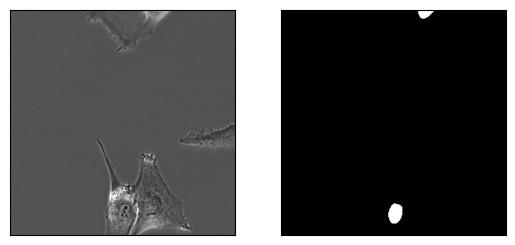

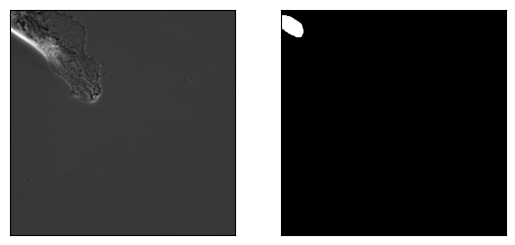

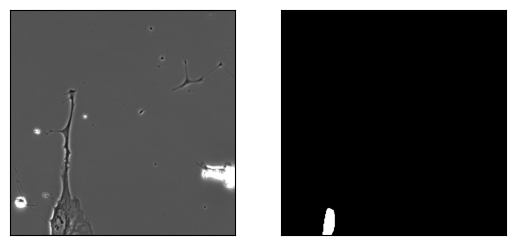

In [17]:
for img_file in img_list[:3]:
    gt_file = dataset_path / 'gt' / 'gt' / img_file.name
    img = cv2.imread(str(img_file), cv2.IMREAD_GRAYSCALE)
    gt = cv2.imread(str(gt_file), cv2.IMREAD_GRAYSCALE)
    fig = plt.figure()
    plt.subplot(121)
    plt.imshow(img, cmap='gray')
    plt.xticks([], [])
    plt.yticks([], [])
    plt.subplot(122)
    plt.imshow(gt, cmap='gray')
    plt.xticks([], [])
    plt.yticks([], [])
    plt.show()
    plt.close()

As we can see, not a lot of space is taken up by the foreground with
respect to the background. This constitutes a **class imbalance**
between foreground and background that will be useful to us in the
following.

It can hence be useful to roughly estimate how imbalanced is, on
average, the amount of foreground with respect to the background.

Let's say we take all the ground truths and average over them the
foreground to background ratio. We define a function to compute
these weights.

In [18]:
def compute_weights(img):
    '''
    Get weights for the image.

    This function takes as input an image in a 2d array format (i.e. a matrix)
    and returns the weights, respectively, for the FOREGROUND and the BACKGROUND.
    Useful for purposes of computing the correct weights for the Weighted
    Binary Cross Entropy.

    Uses numpy backend i.e. for flatten method, etc.

    :param img: 2d image array
    :returns: tuple with the weight for the foreground and for the background
    '''

    img_f = np.where(img.flatten() > 0, 1, 0)
    bg_weight = img_f.sum() / img_f.size

    return (1 - bg_weight, bg_weight)

In [19]:
gt_path = dataset_path / 'gt' / 'gt'
fg_weights = []
for gt_file in gt_path.glob('*.tif'):
    gt = cv2.imread(str(gt_file), cv2.IMREAD_GRAYSCALE)
    fg_weights.append(compute_weights(gt)[0])

In [23]:
print('Foreground ratio mean is', np.mean(fg_weights), 'while background ratio mean is', 1-np.mean(fg_weights), '.')
print('Foreground is', np.mean(fg_weights)/(1-np.mean(fg_weights)), 'times more abundant than background.')

Foreground ratio mean is 0.9916568876931031 while background ratio mean is 0.008343112306896883 .
Foreground is 118.85934783274392 times more abundant than background.


This means that more or less we have two orders of magnitude between the two classes.

## Load the dataset for training

Let us now create a loader function for the dataset. This function will:

- Look for folders in the dataset, and look for subfolders for each class. Since
    we have only one class, our folder structure will be trivial (`img/img` for
    images and `gt/gt` for ground truths).
- Split the dataset in training and test set. For reproducibility, the seed will
    always be initialized to 42.
- Augment the data, since we are tackling a computer vision problem. Operations
    such as *width shift*, *height shift*, *zoom*, *horizontal flip*, *vertical
    flip*, *brightness* change are applied.
- Data generators are returned as a result.

In [24]:
def get_tif_loader(dataset_path='../data/dataset/', train_test_split=0.3, batch_size=14):
    '''
    Default loader for TIFF images.

    This function will lazy load TIFF images for training and validation purposes in Keras
    pipelines. It uses the soon-to-be deprecated component ``ImageDataGenerator`` since the
    new `recommended <https://keras.io/api/data_loading/image/>` ``image_dataset_from_directory``
    does NOT support TIFF images loading.

    The folder pointed to by ``dataset_path`` should contain an ``img/img`` folder for images
    and a ``gt/gt`` folder for masks / ground truth images. The double subfoldering is necessary
    due to the requirement of the ``ImageDataGenerator`` that the dataset should be subfoldered by
    class, but since we have only one class (i.e. the foreground) we will use just one subfolder.

    Data augmentation steps are performed, such as:

    * Width Shift
    * Height Shift
    * Zoom
    * Horizontal Flip
    * Vertical Flip
    * Brightness

    These are also applied as TTA (Test Time Augmentations).

    The masks / ground truth images are transformed in binary arrays of 0/1 values.

    Then two zipped generators for the images and the ground truths, respectively for the training
    and test set subdivided by using the ``train_test_split`` parameter, are returned.

    :param dataset_path: path of the dataset containing the ``gt`` and ``img`` subfolders
    :param train_test_split: ratio of data that will be used for test purposes
    :param batch_size: batch size integer value
    :returns: two generators, one for the training and the other for the test set
    '''
    
    seed = 42
    
    fullds_path = dataset_path
    
    data_gen_dict = partial(
        dict,
        validation_split=train_test_split,
        width_shift_range=0.3,
        height_shift_range=0.3,
        zoom_range=0.3,
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='reflect',
        brightness_range=(0.1, 0.9)
    )
    
    img_data_gen_dict = data_gen_dict()
    gt_data_gen_dict = data_gen_dict(
        preprocessing_function = lambda x: np.where(x>0, 1, 0).astype(x.dtype)
    )
    
    img_data_gen = ImageDataGenerator(**img_data_gen_dict)
    gt_data_gen = ImageDataGenerator(**gt_data_gen_dict)
    
    img_train_gen = img_data_gen.flow_from_directory(
        os.path.join(fullds_path, 'img'),
        seed=seed,
        batch_size=batch_size,
        class_mode=None,
        target_size=(512, 512),
        color_mode='grayscale',
        subset='training'
    )
    
    gt_train_gen = gt_data_gen.flow_from_directory(
        os.path.join(fullds_path, 'gt'),
        seed=seed,
        batch_size=batch_size,
        class_mode=None,
        target_size=(512, 512),
        color_mode='grayscale',
        subset='training'
    )
    
    
    img_test_gen = img_data_gen.flow_from_directory(
        os.path.join(fullds_path, 'img'),
        seed=seed,
        batch_size=1,
        class_mode=None,
        target_size=(512, 512),
        color_mode='grayscale',
        subset='validation'
    )
    
    gt_test_gen = gt_data_gen.flow_from_directory(
        os.path.join(fullds_path, 'gt'),
        seed=seed,
        batch_size=1,
        class_mode=None,
        target_size=(512, 512),
        color_mode='grayscale',
        subset='validation'
    )
    
    train_gen = zip(img_train_gen, gt_train_gen)
    test_gen = zip(img_test_gen, gt_test_gen)

    return train_gen, test_gen

In [27]:
train_gen, test_gen = get_tif_loader(dataset_path='./data/dataset/')

Found 774 images belonging to 1 classes.
Found 774 images belonging to 1 classes.
Found 331 images belonging to 1 classes.
Found 331 images belonging to 1 classes.


## The model for semantic segmentation



## Hyperparameter tuning

## Results

## Discussion

## Further research